## IBM Data Science Profession Capstone Project

### Import Librariesand Packages

In [435]:
# Import libraries
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim
import requests as req
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import bs4
import matplotlib.pyplot as plt

### Import and Prepare Data

In [436]:
# Import crime data from csv
chicago_crime_df = pd.read_csv('crimes_2014-pres.csv')

In [437]:
chicago_crime_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,03/18/2015 07:44:00 PM,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,...,28.0,25.0,04B,1144606.0,1903566.0,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,"(41.891398861, -87.744384567)"
1,10000094,HY190059,03/18/2015 11:00:00 PM,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,...,15.0,67.0,26,1166468.0,1860715.0,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319,"(41.773371528, -87.665319468)"
2,10000095,HY190052,03/18/2015 10:45:00 PM,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,4.0,39.0,08B,1185075.0,1875622.0,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,"(41.81386068, -87.596642837)"
3,10000096,HY190054,03/18/2015 10:30:00 PM,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,...,3.0,40.0,08B,1178033.0,1870804.0,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619,"(41.800802415, -87.622619343)"
4,10000097,HY189976,03/18/2015 09:00:00 PM,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,...,28.0,25.0,03,1144920.0,1898709.0,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354,"(41.878064761, -87.743354013)"


In [438]:
# Get dataframe info to determine non-relevant columns and columns whose datatypes may need to be changed
chicago_crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399203 entries, 0 to 1399202
Data columns (total 22 columns):
ID                      1399203 non-null int64
Case Number             1399203 non-null object
Date                    1399203 non-null object
Block                   1399203 non-null object
IUCR                    1399203 non-null object
Primary Type            1399203 non-null object
Description             1399203 non-null object
Location Description    1395407 non-null object
Arrest                  1399203 non-null bool
Domestic                1399203 non-null bool
Beat                    1399203 non-null int64
District                1399202 non-null float64
Ward                    1399195 non-null float64
Community Area          1399201 non-null float64
FBI Code                1399203 non-null object
X Coordinate            1383385 non-null float64
Y Coordinate            1383385 non-null float64
Year                    1399203 non-null int64
Updated On              1

In [439]:
# Drop columns that aren't needed for this project
# Note that specific coordinates of crime is removed here, but will be later replaced with the community coordinates
nonrelevant_columns = ['Case Number', 'Date', 'Block', 'IUCR', 'Domestic', 'Beat', 'District', 'Ward', 'FBI Code', 
                       'X Coordinate', 'Y Coordinate', 'Updated On', 'Latitude', 'Longitude', 'Location' ]
chicago_crime_df.drop(columns= nonrelevant_columns, inplace=True)

In [440]:
# Rename columns
name_changes = {'Primary Type': "Category", "Location Description": "Location_Description", "Community Area": "community_number"}
chicago_crime_df.rename(columns= name_changes, inplace=True)

In [441]:
#Drop rows with NaN values 
chicago_crime_df.dropna(subset=['community_number'], axis='rows', inplace=True)

In [442]:
# Filter out rows with Community_Area = 0. There are seven of such records, but no communty area numbered 0
chicago_crime_df = chicago_crime_df[chicago_crime_df.community_number != 0]

In [443]:
# Import Community names
community_names_df = pd.read_csv('chicago_communities.csv')
community_names_df.head()

,community_number,community_name
0,1,Rogers Park
1,2,West Ridge
2,3,Uptown
3,4,Lincoln Square
4,5,North Center


In [444]:
# Get central locations of communities and add to community_names_df
#Create geolocator object
geolocator = Nominatim(user_agent = "chicago_capstone")

# Add latitude and longitude columns
community_names_df['latitude'] = 1.0
community_names_df['longitude'] = 1.0

# Get coordinates and assign to the columns
for index, row in community_names_df[['community_name']].iterrows():
    # Create address as community name + city name
    address = row['community_name'] + ', Chicago'
    
    # Get central location for each community    
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    # Add coordinates to data frame
    community_names_df.loc[index, ('latitude')] = latitude
    community_names_df.loc[index, ('longitude')] = longitude

In [445]:
# Show updated community_names_df
community_names_df.head()

,community_number,community_name,latitude,longitude
0,1,Rogers Park,42.010531,-87.670748
1,2,West Ridge,42.003548,-87.696243
2,3,Uptown,41.966630,-87.655546
3,4,Lincoln Square,42.266997,-71.798432
4,5,North Center,41.956107,-87.679160


In [446]:
# Community Area 51's coordinates will be off, so modify them with the correct coordinates from a Google search
community_names_df.loc[50,('latitude')] = 41.6737
community_names_df.loc[50,('longitude')] = -87.5753

In [447]:
# Visualize Chicago community areas on map
# Create Map with Folium
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add markers
for lat, lng, comm_num, comm_name in zip(community_names_df['latitude'], community_names_df['longitude'], 
                                         community_names_df['community_number'], community_names_df['community_name']):
    label = '{}, {}'.format(comm_num, comm_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)

map_chicago

In [448]:
# Merge chicago_crimes_df and community_names_df on community_number
chicago_crime_df = chicago_crime_df.merge(community_names_df, how='inner', on='community_number')

In [449]:
# Show head of updated chicago_crimes_df
chicago_crime_df.head()

,ID,Category,Description,Location_Description,Arrest,community_number,Year,community_name,latitude,longitude
0,10000092,BATTERY,AGGRAVATED: HANDGUN,STREET,False,25.0,2015,Austin,41.887876,-87.764851
1,10000097,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,25.0,2015,Austin,41.887876,-87.764851
2,10000111,THEFT,RETAIL THEFT,GAS STATION,True,25.0,2015,Austin,41.887876,-87.764851
3,10000123,WEAPONS VIOLATION,UNLAWFUL USE HANDGUN,VEHICLE NON-COMMERCIAL,True,25.0,2015,Austin,41.887876,-87.764851
4,10000169,ASSAULT,SIMPLE,APARTMENT,False,25.0,2015,Austin,41.887876,-87.764851


In [450]:
# Check shape of chicago_crimes_df
chicago_crime_df.shape

(1399194, 10)

### Exploratory Data Analysis

In [451]:
# Rank Community areas from most crimes to least crimes within the period (2014 to present)
sorted_crimed_df = chicago_crime_df[['community_name', 'Category']].groupby('community_name').count()
sorted_crime_chart_data = sorted_crimed_df.sort_values(by='Category', ascending=False).head()
sorted_crime_chart_data

,Category
community_name,
Austin,86502
Near North Side,56797
Loop,47857
North Lawndale,46348
South Shore,45849


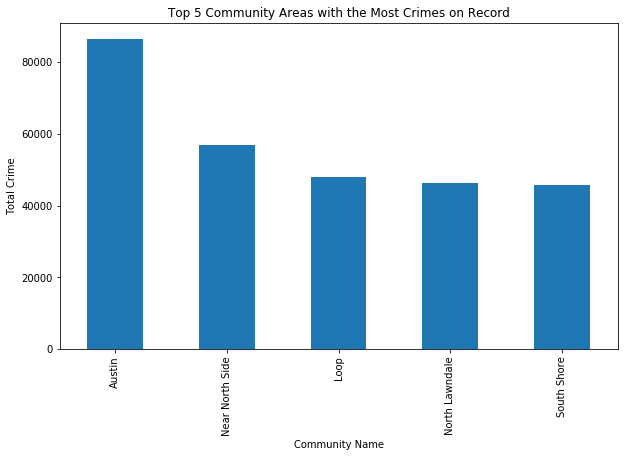

In [452]:
# Show chart of top 5 communities with highest crime rates
sorted_crime_chart_data.plot(kind ='bar', figsize=(10, 6), colormap=cm.tab10, legend=None)
plt.xlabel('Community Name') 
plt.ylabel('Total Crime') 
plt.title('Top 5 Community Areas with the Most Crimes on Record')

plt.show()

In [453]:
# Aggregate crimes by year
crime_year_df = chicago_crime_df[['Year', 'Category']].groupby('Year').count()
crime_year_data = crime_year_df.sort_values(by='Year', ascending=True)
crime_year_data

,Category
Year,
2014,275291
2015,264077
2016,268998
2017,268097
2018,266271
2019,56460


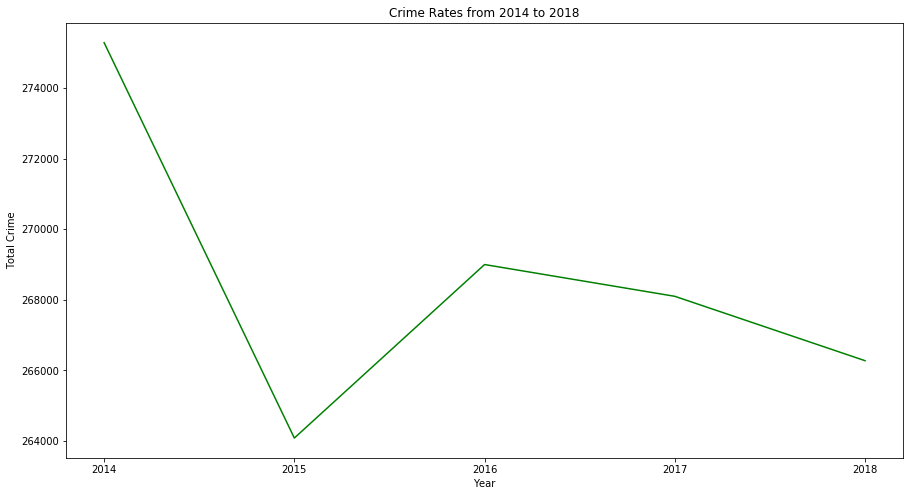

In [454]:
# Show crime count by year, excluding 2019 since the year is yet to be over
# Create list of years
years = list(map(str, range(2014, 2019)))

# Create Line Chart
plt.plot(years, crime_year_data['Category'][:5], color='green')
plt.xlabel('Year') 
plt.ylabel('Total Crime') 
plt.title('Crime Rates from 2014 to 2018')
plt.rcParams["figure.figsize"] = [10,6]

plt.show()

In [455]:
# Create an aggregate of crimes by categories by year, excluding 2019
category_year_aggregate_df = chicago_crime_df[['Category', 'Year', 'ID']].groupby(['Category', 'Year']).count().reset_index()
category_year_aggregate_df = category_year_aggregate_df[category_year_aggregate_df.Year != 2019]
category_year_aggregate_df.head(6)

,Category,Year,ID
0,ARSON,2014,397
1,ARSON,2015,453
2,ARSON,2016,516
3,ARSON,2017,444
4,ARSON,2018,372
6,ASSAULT,2014,16902


In [456]:
# Create a crime-to-year matrix
# Create dataframe with uniques crime categories as index
crime_category_trend_df = pd.DataFrame(chicago_crime_df.Category.unique())
crime_category_trend_df.rename(columns={0:'Category'}, inplace=True)
crime_category_trend_df.set_index(keys='Category', inplace=True)

#Add years as columns to the data frame to form matrix
crime_category_trend_df[2014] = 0
crime_category_trend_df[2015] = 0
crime_category_trend_df[2016] = 0
crime_category_trend_df[2017] = 0
crime_category_trend_df[2018] = 0

# Populate matrix with data from category_year_aggregate_df
for index, row in category_year_aggregate_df.iterrows():
    category = row['Category']
    year = row['Year']
    aggregate = row['ID']
    crime_category_trend_df.loc[category, (year)] = aggregate 

# Add a total column to matrix
crime_category_trend_df['Total'] = crime_category_trend_df.sum(axis=1)

# Show part of matrix
crime_category_trend_df.head(10)

,2014,2015,2016,2017,2018,Total
Category,,,,,,
BATTERY,49447,48919,50290,49214,49781,247651
ROBBERY,9799,9639,11960,11877,9683,52958
THEFT,61562,57337,61603,64346,65082,309930
WEAPONS VIOLATION,3114,3364,3449,4686,5450,20063
ASSAULT,16902,17045,18740,19302,20376,92365
CRIMINAL DAMAGE,27797,28674,31018,29042,27806,144337
NARCOTICS,29117,23884,13293,11658,12987,90939
DECEPTIVE PRACTICE,15708,16054,18867,19028,18733,88390
MOTOR VEHICLE THEFT,9912,10068,11294,11406,9988,52668


In [457]:
# Normalize matrix by dividing yearly aggregates by the total for the category

# First change datatype of year columns to float to allow for decimals
change_list = {2014:'float', 2015:'float', 2016:'float', 2017:'float', 2018:'float'}
crime_category_trend_df = crime_category_trend_df.astype(change_list)

# Proceed with Normalization
for category, row in crime_category_trend_df.iterrows():
    for year in range(2014, 2019):
        crime_category_trend_df.loc[category, (year)]= float(round(row[year]/row['Total'], 4))

# Show normalized matrix
crime_category_trend_df.head(10)

,2014,2015,2016,2017,2018,Total
Category,,,,,,
BATTERY,0.1997,0.1975,0.2031,0.1987,0.2010,247651
ROBBERY,0.1850,0.1820,0.2258,0.2243,0.1828,52958
THEFT,0.1986,0.1850,0.1988,0.2076,0.2100,309930
WEAPONS VIOLATION,0.1552,0.1677,0.1719,0.2336,0.2716,20063
ASSAULT,0.1830,0.1845,0.2029,0.2090,0.2206,92365
CRIMINAL DAMAGE,0.1926,0.1987,0.2149,0.2012,0.1926,144337
NARCOTICS,0.3202,0.2626,0.1462,0.1282,0.1428,90939
DECEPTIVE PRACTICE,0.1777,0.1816,0.2135,0.2153,0.2119,88390
MOTOR VEHICLE THEFT,0.1882,0.1912,0.2144,0.2166,0.1896,52668


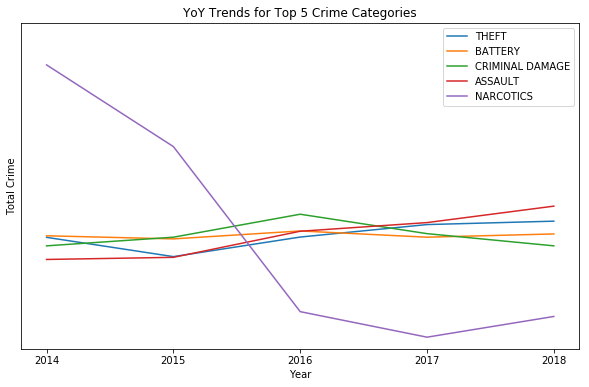

In [458]:
# Chart the trend of the top 5 crime categories
# Prepare dataframe for charting by selecting top crime categories and transposing the data
trend_chart_data = crime_category_trend_df.sort_values(by='Total', ascending=False).head().transpose()

# Create Line Chart
plt.plot(years, trend_chart_data[trend_chart_data.columns][:5])
plt.xlabel('Year') 
plt.ylabel('Total Crime') 
plt.title('YoY Trends for Top 5 Crime Categories')
plt.legend(trend_chart_data.columns)
plt.ylim(.12,0.35)
plt.yticks(ticks=[], labels=[])
plt.rcParams["figure.figsize"] = [15,8]

plt.show()

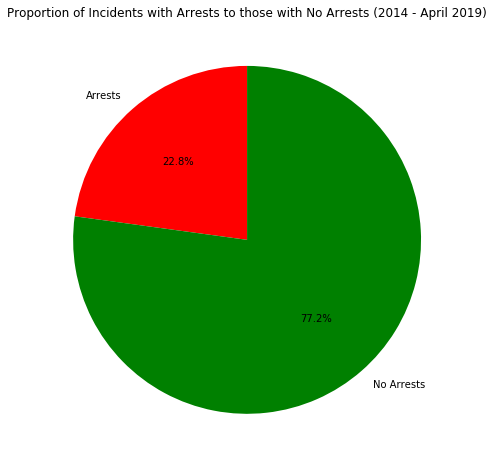

In [459]:
# Show ratio of arrest to no arrests in pie chart
with_arrests = len(chicago_crime_df[chicago_crime_df.Arrest == True])
with_no_arrests = len(chicago_crime_df[chicago_crime_df.Arrest == False])

arrest_slices = [with_arrests, with_no_arrests]
labels = ['Arrests', 'No Arrests']
colors = ['r', 'g']

plt.pie(arrest_slices, labels=labels, colors=colors, startangle=90, autopct='%.1f%%')
plt.title('Proportion of Incidents with Arrests to those with No Arrests (2014 - April 2019)')
plt.rcParams["figure.figsize"] = [15,8]

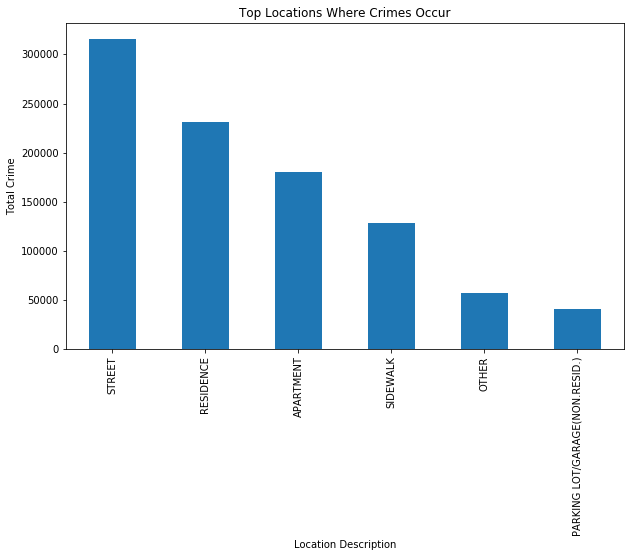

In [460]:
#Create a chart thank ranks the top locations where crimes occur
crime_location_aggregate = chicago_crime_df[['Location_Description', 'ID']].groupby('Location_Description').count()
crime_location_aggregate = crime_location_aggregate.sort_values(by='ID', ascending=False).head(6)

crime_location_aggregate.plot(kind ='bar', figsize=(10, 6), colormap=cm.tab10, legend=None)
plt.xlabel('Location Description') 
plt.ylabel('Total Crime') 
plt.title('Top Locations Where Crimes Occur')

plt.show()

### Machine Learning

#### Clustering (K-Means)

In [461]:
# Create a subset of the data to use for clustering computation. All rows are included, just columns are filtered
cluster_dataset_df = chicago_crime_df[['community_number','community_name', 'latitude', 'longitude', 'Category']]

# Show number of unique crime categories
print('There are {x} unique crime categories'.format(x= len(cluster_dataset_df.Category.unique())))

There are 33 unique crime categories


In [462]:
# Create matrix of community areas to crime categories using one hot encoding
chicago_onehot_df = pd.get_dummies(cluster_dataset_df[['Category']], prefix="", prefix_sep="")

# Add community area names to onehot dataframe
chicago_onehot_df['community_name'] =  cluster_dataset_df['community_name']

# Move community_name column from index 33 to index 0
ordered_column_list = [chicago_onehot_df.columns[33]] + list(chicago_onehot_df.columns[:33])
chicago_onehot_df = chicago_onehot_df[ordered_column_list]

chicago_onehot_df.head()

,community_name,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER NARCOTIC VIOLATION,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
0,Austin,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Austin,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [463]:
# Print shape the shape of chicago_onehot_df
chicago_onehot_df.shape

(1399194, 34)

In [464]:
# Group the rows by community area and compute the average frequency of occurence for each crime category
chicago_grouped = chicago_onehot_df.groupby('community_name').mean().reset_index()
chicago_grouped.head()

,community_name,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER NARCOTIC VIOLATION,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
0,Albany Park,0.001258,0.060932,0.186886,0.059910,0.000079,0.005818,0.137118,0.018476,0.054957,...,0.000000,0.060303,0.002280,0.000079,0.006447,0.048589,0.007391,0.000314,0.234610,0.009749
1,Archer Heights,0.001670,0.061378,0.151983,0.077453,0.000209,0.005010,0.147808,0.015866,0.059081,...,0.000000,0.054071,0.004802,0.000418,0.008768,0.034029,0.004802,0.000835,0.235282,0.010856
2,Armour Square,0.000359,0.061444,0.173374,0.044556,0.000000,0.004132,0.094682,0.039526,0.087136,...,0.000000,0.037010,0.000359,0.000000,0.004851,0.080848,0.004312,0.000539,0.274165,0.010600
3,Ashburn,0.002303,0.073463,0.165809,0.070469,0.000000,0.005143,0.140554,0.020035,0.073540,...,0.000077,0.074691,0.000000,0.000000,0.006371,0.039226,0.002840,0.000921,0.201505,0.008444
4,Auburn Gresham,0.001680,0.086584,0.223278,0.056352,0.000276,0.005440,0.112128,0.026171,0.049433,...,0.000000,0.074601,0.002256,0.000025,0.007821,0.046024,0.002557,0.000777,0.155821,0.026898


In [465]:
# Function to sort categories in descending order
def return_most_common_categories(row, num_top_categories):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_categories]

In [466]:
# Function to create dataframe of community areas and their top x categories
def return_top_x_frame(num_top_categories, grouped_df):
    indicators = ['st', 'nd', 'rd']
    
    # Create columns according to number of top venues
    columns = ['community_name']
    for ind in np.arange(num_top_categories):
        try:
            columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Category'.format(ind+1))
            
    # Create new dataframe
    category_sorted_df = pd.DataFrame(columns=columns)
    category_sorted_df['community_name'] = grouped_df['community_name']
    
    # Load ranked categories into the new dataframe
    for ind in np.arange(grouped_df.shape[0]):
        category_sorted_df.iloc[ind, 1:] = return_most_common_categories(grouped_df.iloc[ind, :], num_top_categories)
    
    return category_sorted_df

In [467]:
# return_top_x_frame to create a dataframe of community areas and their top 15 crime categories
crime_category_sorted_df = return_top_x_frame(15, chicago_grouped)
crime_category_sorted_df.head()

,community_name,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category,11th Most Common Category,12th Most Common Category,13th Most Common Category,14th Most Common Category,15th Most Common Category
0,Albany Park,THEFT,BATTERY,CRIMINAL DAMAGE,ASSAULT,OTHER OFFENSE,BURGLARY,MOTOR VEHICLE THEFT,DECEPTIVE PRACTICE,ROBBERY,NARCOTICS,CRIMINAL TRESPASS,WEAPONS VIOLATION,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,PUBLIC PEACE VIOLATION
1,Archer Heights,THEFT,BATTERY,CRIMINAL DAMAGE,BURGLARY,MOTOR VEHICLE THEFT,ASSAULT,DECEPTIVE PRACTICE,OTHER OFFENSE,NARCOTICS,ROBBERY,CRIMINAL TRESPASS,WEAPONS VIOLATION,OFFENSE INVOLVING CHILDREN,PUBLIC PEACE VIOLATION,CRIM SEXUAL ASSAULT
2,Armour Square,THEFT,BATTERY,CRIMINAL DAMAGE,DECEPTIVE PRACTICE,ROBBERY,ASSAULT,BURGLARY,MOTOR VEHICLE THEFT,CRIMINAL TRESPASS,OTHER OFFENSE,NARCOTICS,WEAPONS VIOLATION,PUBLIC PEACE VIOLATION,OFFENSE INVOLVING CHILDREN,SEX OFFENSE
3,Ashburn,THEFT,BATTERY,CRIMINAL DAMAGE,OTHER OFFENSE,DECEPTIVE PRACTICE,ASSAULT,BURGLARY,MOTOR VEHICLE THEFT,ROBBERY,NARCOTICS,CRIMINAL TRESPASS,OFFENSE INVOLVING CHILDREN,WEAPONS VIOLATION,PUBLIC PEACE VIOLATION,CRIM SEXUAL ASSAULT
4,Auburn Gresham,BATTERY,THEFT,CRIMINAL DAMAGE,ASSAULT,OTHER OFFENSE,NARCOTICS,BURGLARY,DECEPTIVE PRACTICE,ROBBERY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,OFFENSE INVOLVING CHILDREN,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER


In [468]:
# Use the K-means clustering algorithm to cluster the community areas
num_of_clusters = 2
chicago_grouped_clustering = chicago_grouped.drop('community_name', 1)

kmeans = KMeans(n_clusters=num_of_clusters, random_state=0).fit(chicago_grouped_clustering)

In [469]:
# Add cluster labels to crime_category_sorted_df and merge it with cluster_dataset_df to add coordinates
crime_category_sorted_df.insert(0, 'Cluster Labels', kmeans.labels_)
chicago_crime_merged = community_names_df
chicago_crime_merged = chicago_crime_merged.join(crime_category_sorted_df.set_index('community_name'), on='community_name')

chicago_crime_merged.head()

,community_number,community_name,latitude,longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category,11th Most Common Category,12th Most Common Category,13th Most Common Category,14th Most Common Category,15th Most Common Category
0,1,Rogers Park,42.010531,-87.670748,1,THEFT,BATTERY,CRIMINAL DAMAGE,ASSAULT,DECEPTIVE PRACTICE,OTHER OFFENSE,BURGLARY,CRIMINAL TRESPASS,NARCOTICS,ROBBERY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIM SEXUAL ASSAULT,OFFENSE INVOLVING CHILDREN,SEX OFFENSE
1,2,West Ridge,42.003548,-87.696243,1,THEFT,BATTERY,CRIMINAL DAMAGE,DECEPTIVE PRACTICE,OTHER OFFENSE,BURGLARY,ASSAULT,MOTOR VEHICLE THEFT,ROBBERY,NARCOTICS,CRIMINAL TRESPASS,OFFENSE INVOLVING CHILDREN,WEAPONS VIOLATION,SEX OFFENSE,PUBLIC PEACE VIOLATION
2,3,Uptown,41.966630,-87.655546,0,THEFT,BATTERY,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,ASSAULT,OTHER OFFENSE,NARCOTICS,BURGLARY,CRIMINAL TRESPASS,MOTOR VEHICLE THEFT,ROBBERY,CRIM SEXUAL ASSAULT,PUBLIC PEACE VIOLATION,OFFENSE INVOLVING CHILDREN,WEAPONS VIOLATION
3,4,Lincoln Square,42.266997,-71.798432,0,THEFT,BATTERY,CRIMINAL DAMAGE,DECEPTIVE PRACTICE,OTHER OFFENSE,BURGLARY,ASSAULT,MOTOR VEHICLE THEFT,NARCOTICS,CRIMINAL TRESPASS,ROBBERY,CRIM SEXUAL ASSAULT,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,WEAPONS VIOLATION
4,5,North Center,41.956107,-87.679160,0,THEFT,CRIMINAL DAMAGE,DECEPTIVE PRACTICE,BATTERY,BURGLARY,OTHER OFFENSE,ASSAULT,MOTOR VEHICLE THEFT,ROBBERY,CRIMINAL TRESPASS,NARCOTICS,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,CRIM SEXUAL ASSAULT,PUBLIC PEACE VIOLATION


In [470]:
# Use the folium library to visualize the resilting clusters
crime_cluster_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# Set color scheme for the clusters
x = np.arange(num_of_clusters)
ys = [i + x + (i*x)**2 for i in range(num_of_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))

# Reset colors variable to matplotlib.colors in order to have access to rgb2hex. colors is changed somewhere else above
import matplotlib.colors as colors
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add point markers to map
markers_colors = []
for lat, lon, poi, num, cluster in zip(chicago_crime_merged['latitude'], chicago_crime_merged['longitude'], chicago_crime_merged['community_name'], chicago_crime_merged['community_number'], chicago_crime_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + '({num}) \n'.format(num=num) + ' Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(crime_cluster_map)

# Show annotated map
crime_cluster_map

#### Classification (Logistic Regression) and Evaluation

In [471]:
# Set Foursquare CRedentials
CLIENT_ID = 'enter client ID' 
CLIENT_SECRET = 'enter client secret'
VERSION = '20180605'

# Limit of number of venues returned by API
LIMIT = 100

In [472]:
# Create function to get venues from each community area
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = req.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            #v['venue']['name'], 
            #v['venue']['location']['lat'], 
            #v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['community_name', 
                  'latitude', 
                  'longitude', 
                  #'Venue', 
                  #'Venue Latitude', 
                  #'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [473]:
# Call getNearbyVenues function to get venue categories in each community area in the community_names_df
chicago_venues_df = getNearbyVenues(names=community_names_df['community_name'],
                                   latitudes=community_names_df['latitude'],
                                   longitudes=community_names_df['longitude']
                                  )
chicago_venues_df.head()

,community_name,latitude,longitude,Venue Category
0,Rogers Park,42.010531,-87.670748,Mexican Restaurant
1,Rogers Park,42.010531,-87.670748,Grocery Store
2,Rogers Park,42.010531,-87.670748,Pet Store
3,Rogers Park,42.010531,-87.670748,Mexican Restaurant
4,Rogers Park,42.010531,-87.670748,Coffee Shop


In [474]:
# Print unique categories of venues in data set
print('There are {} unique venue categories.'.format(len(chicago_venues_df['Venue Category'].unique())))

There are 246 unique venue categories.


In [475]:
# Use one hot encoding to create matrix of community areas to venue categories
chicago_venues_onehot_df = pd.get_dummies(chicago_venues_df[['Venue Category']], prefix="", prefix_sep="")

# Add community area names to the one hot data frame
chicago_venues_onehot_df['community_name'] = chicago_venues_df['community_name']

# Move community name column from index 246 to index 0
ordered_columns = [chicago_venues_onehot_df.columns[246]] + list(chicago_venues_onehot_df.columns[:246])
chicago_venues_onehot_df = chicago_venues_onehot_df[ordered_columns]

chicago_venues_onehot_df.head()

,community_name,ATM,Accessories Store,African Restaurant,Airport Lounge,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,...,Video Store,Vietnamese Restaurant,Vineyard,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [476]:
# Compute average frequency of venues per community area to use for classification
chicago_venues_onehot_mean_df = chicago_venues_onehot_df.groupby('community_name').mean()
chicago_classification = chicago_venues_onehot_mean_df.merge(chicago_crime_merged[['community_name', 'Cluster Labels']], 
                                  how='inner', on='community_name')
chicago_classification = chicago_classification[[chicago_classification.columns[247]] + list(chicago_classification.columns[:247])]
chicago_classification.head()

,Cluster Labels,community_name,ATM,Accessories Store,African Restaurant,Airport Lounge,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Video Store,Vietnamese Restaurant,Vineyard,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,1,Albany Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,1,Archer Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0
2,0,Armour Square,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,1,Ashburn,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,1,Auburn Gresham,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [477]:
# Create features dataframe for classification as X
X = chicago_classification[chicago_classification.columns[2:]].values
# Show sample
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.04347826, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [478]:
# Create lables for classification as y
y = chicago_classification['Cluster Labels'].values
# Show sample
y

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1])

In [479]:
# Split datasets into training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [480]:
# Use Logistic Regression to build classification model to predict an areas cluster based on venues in the area
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01, multi_class='auto', solver='lbfgs').fit(X_train,y_train)
LR_model

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [481]:
yhat = LR_model.predict(X_test)
yhat

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [482]:
# Evaluate model accuracy
# import evaluation metrics functions
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

# Run functions and print results
LR_yhat_prob = LR_model.predict_proba(X_test)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(y_test, yhat))
print("LR F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(y_test, LR_yhat_prob))

LR Jaccard index: 0.57
LR F1-score: 0.41
LR LogLoss: 0.77


C:\Users\kebbi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Multiple Regression and Evaluation

In [483]:
# Create data set for multiple regression
chicago_multiple_reg = chicago_venues_onehot_mean_df.merge(sorted_crimed_df, how='inner', on='community_name')
chicago_multiple_reg = chicago_multiple_reg.rename(columns={'Category':'Total'})
chicago_multiple_reg = chicago_multiple_reg[[chicago_multiple_reg.columns[246]] + list(chicago_multiple_reg.columns[:246])]
chicago_multiple_reg.head()

,Total,ATM,Accessories Store,African Restaurant,Airport Lounge,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,...,Video Store,Vietnamese Restaurant,Vineyard,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
community_name,,,,,,,,,,,,,,,,,,,,,
Albany Park,12719,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Archer Heights,4790,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0
Armour Square,5566,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Ashburn,13027,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Auburn Gresham,39892,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [484]:
# Create features array
X = chicago_multiple_reg[chicago_multiple_reg.columns[1:]].values

In [485]:
# Create lables array
y = chicago_multiple_reg['Total'].values

In [486]:
# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [487]:
# Create and fir regression model
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [489]:
# Predict with regression model
yhat = regr.predict(X_test)
print("Residual sum of squares: %.2f"
      % np.mean((yhat - y_test) ** 2))

# print variance
print('Coefficient of Determination: %.2f' % regr.score(X_test, y_test))

Residual sum of squares: 711736159.81
Coefficient of Determination: -0.67


The End!!!